## 1. Import required Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
# Used for reduction of samples
import random
# Libraries used for the ML model training and classification
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# Cleanlab import
from cleanlab.filter import find_label_issues
# Model training libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# For model optimisation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Loading the Data

In [ ]:
# Directory containing folders of images
image_dir = 'CHS2406_Coursework2_Data_Repository'
labels = []
data = []

# Allowed image extensions
allowed_extensions = {'.png', '.jpg', '.jpeg', '.JPG'}

# Target size for resizing images
img_size = (150, 150)   

# Iterate through subfolder
for label in os.listdir(image_dir):
    subfolder_path = os.path.join(image_dir, label)
    
    if os.path.isdir(subfolder_path):
        # Assign label based on folder name
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)
            
            # Check if the file has an allowed extension
            if any(image_file.lower().endswith(ext) for ext in allowed_extensions):
                try:
                    # Load the image with the specified target size and RGB mode
                    image = tf.keras.preprocessing.image.load_img(
                        image_path, 
                        color_mode='rgb', 
                        target_size=img_size
                    )
                    
                    # Convert the image to a NumPy array
                    image = np.array(image)
                    
                    # Append the label and image to the respective lists
                    labels.append(int(label[-1]))
                    data.append(image)
                
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

print("Number of labels:", len(labels))
print(f"Number of images: {len(data)}")

Number of labels: 12583
Number of images: 12583


#### Converting the data and labels into NumPy arrays and normalizing the pixels

In [96]:
# Convert to numpy arrays

data = np.array(data) / 255.0  # Normalize pixel values
labels = np.array(labels)  # Adjust labels to start from 0

print(f"Data shape: {data}")
print(f"Labels shape: {labels.shape}")

Data shape: [[[[1.08555533e-05 1.04333929e-05 9.95092385e-06]
   [1.09158619e-05 1.07349360e-05 1.01921584e-05]
   [1.14586396e-05 1.10967878e-05 1.03730843e-05]
   ...
   [3.67882639e-06 2.89481421e-06 1.74895025e-06]
   [3.85975228e-06 3.31697462e-06 2.29172792e-06]
   [3.25666599e-06 2.47265381e-06 1.44740711e-06]]

  [[1.08555533e-05 1.02524670e-05 9.52876345e-06]
   [1.05540101e-05 9.58907208e-06 8.08135634e-06]
   [9.89061522e-06 8.86536852e-06 7.17672690e-06]
   ...
   [1.53183919e-05 1.53787005e-05 1.49565401e-05]
   [3.49790051e-06 2.71388832e-06 1.74895025e-06]
   [5.48808528e-06 4.94530761e-06 4.04067817e-06]]

  [[2.59327106e-06 2.53296244e-06 2.41234518e-06]
   [9.89061522e-06 8.92567715e-06 7.53857868e-06]
   [9.76999796e-06 8.80505989e-06 7.23703553e-06]
   ...
   [1.29060467e-05 1.23029604e-05 1.15792568e-05]
   [1.42931452e-05 1.42328365e-05 1.39312934e-05]
   [3.07574010e-06 2.83450558e-06 2.17111066e-06]]

  ...

  [[9.76999796e-06 8.38289949e-06 6.45302335e-06]
   [

#### Resizing the data as it is giving memory error on 12000 images

In [4]:
resizing_data = 12538

random_indices = np.random.choice(len(data), size =resizing_data, replace=False)

reduced_data = data[random_indices]
reduced_labels = labels[random_indices]

print(f"Cropped data shape: {reduced_data.shape}")
print(f"Cropped labels shape : {reduced_labels.shape}")


Cropped data shape: (12538, 28, 28, 3)
Cropped labels shape : (12538,)


In [97]:
# Convert to numpy arrays

data = np.array(reduced_data) / 255.0  # Normalize pixel values
labels = np.array(reduced_labels)  # Adjust labels to start from 0

print(f"Data shape: {reduced_data}")
print(f"Labels shape: {reduced_labels.shape}")

Data shape: [[[[0.70588235 0.67843137 0.64705882]
   [0.70980392 0.69803922 0.6627451 ]
   [0.74509804 0.72156863 0.6745098 ]
   ...
   [0.23921569 0.18823529 0.11372549]
   [0.25098039 0.21568627 0.14901961]
   [0.21176471 0.16078431 0.09411765]]

  [[0.70588235 0.66666667 0.61960784]
   [0.68627451 0.62352941 0.5254902 ]
   [0.64313725 0.57647059 0.46666667]
   ...
   [0.99607843 1.         0.97254902]
   [0.22745098 0.17647059 0.11372549]
   [0.35686275 0.32156863 0.2627451 ]]

  [[0.16862745 0.16470588 0.15686275]
   [0.64313725 0.58039216 0.49019608]
   [0.63529412 0.57254902 0.47058824]
   ...
   [0.83921569 0.8        0.75294118]
   [0.92941176 0.9254902  0.90588235]
   [0.2        0.18431373 0.14117647]]

  ...

  [[0.63529412 0.54509804 0.41960784]
   [0.64313725 0.55294118 0.43137255]
   [0.65098039 0.56078431 0.43921569]
   ...
   [0.65490196 0.49803922 0.35686275]
   [0.70196078 0.54509804 0.40392157]
   [0.70980392 0.55294118 0.41176471]]

  [[0.64313725 0.55294118 0.43137

* Getting a count of images on each stage 

In [6]:
from collections import Counter

label_distribution = Counter(reduced_labels)
label_distribution

Counter({4: 1640,
         1: 1615,
         6: 1604,
         7: 1594,
         8: 1592,
         2: 1587,
         3: 1585,
         5: 1321})

In [7]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
reduced_labels = reduced_labels.reshape(-1, 1)  # Reshape to 2D array for encoder
reduced_labels = encoder.fit_transform(reduced_labels)
reduced_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [8]:
# After processing all images
print("Image data:", reduced_data)
print("Image Labels:", reduced_labels)
reduced_data.shape

Image data: [[[[0.70588235 0.67843137 0.64705882]
   [0.70980392 0.69803922 0.6627451 ]
   [0.74509804 0.72156863 0.6745098 ]
   ...
   [0.23921569 0.18823529 0.11372549]
   [0.25098039 0.21568627 0.14901961]
   [0.21176471 0.16078431 0.09411765]]

  [[0.70588235 0.66666667 0.61960784]
   [0.68627451 0.62352941 0.5254902 ]
   [0.64313725 0.57647059 0.46666667]
   ...
   [0.99607843 1.         0.97254902]
   [0.22745098 0.17647059 0.11372549]
   [0.35686275 0.32156863 0.2627451 ]]

  [[0.16862745 0.16470588 0.15686275]
   [0.64313725 0.58039216 0.49019608]
   [0.63529412 0.57254902 0.47058824]
   ...
   [0.83921569 0.8        0.75294118]
   [0.92941176 0.9254902  0.90588235]
   [0.2        0.18431373 0.14117647]]

  ...

  [[0.63529412 0.54509804 0.41960784]
   [0.64313725 0.55294118 0.43137255]
   [0.65098039 0.56078431 0.43921569]
   ...
   [0.65490196 0.49803922 0.35686275]
   [0.70196078 0.54509804 0.40392157]
   [0.70980392 0.55294118 0.41176471]]

  [[0.64313725 0.55294118 0.43137

(12538, 28, 28, 3)

In [9]:
# Check class distribution in the reduced labels
from collections import Counter

label_distribution = Counter(reduced_labels.argmax(axis=1))
label_distribution

Counter({3: 1640,
         0: 1615,
         5: 1604,
         6: 1594,
         7: 1592,
         1: 1587,
         2: 1585,
         4: 1321})

In [10]:
print(f"Number of images: {len(reduced_data)}")

Number of images: 12538


## 3. Data Splitting

To make sure our model is trained, validated, and tested on different parts of the data, I split the dataset into training, validation, and test sets. This helps us check how well the model performs and generalizes.

1. **Initial Split**: I first split the data into training and test sets with an 80-20 split. So, 80% of the data is for training and 20% for testing.
2. **Further Split**: The training set is then split into training and validation sets with a 90-10 split. This means 90% of the training set is used for training and 10% for validation.

The final split looks like this:
- **Training Set**: 72% of the original data
- **Validation Set**: 8% of the original data
- **Test Set**: 20% of the original data

This way, the model gets trained on a big chunk of the data, while also being validated and tested on separate parts to see how well it performs.


In [98]:
# First split into train and test
X_train, X_test, y_train, y_test = train_test_split(reduced_data, reduced_labels, test_size=0.1, random_state=42)

# Then split the temp set into validation and test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Number of training images: {X_train.shape[0]}")
print(f"Number of validation images: {X_val.shape[0]}")
print(f"Number of test images: {X_test.shape[0]}")
print(f"Number of training labels: {y_train.shape[0]}")
print(f"Number of validation labels: {y_val.shape[0]}")
print(f"Number of test labels: {y_test.shape[0]}")

Number of training images: 10155
Number of validation images: 1129
Number of test images: 1254
Number of training labels: 10155
Number of validation labels: 1129
Number of test labels: 1254


#### Building and Compiling the CNN Model

Here's a brief overview of the CNN model I built using the Keras Sequential API. The model includes several layers designed to classify images into 8 classes:

- **Conv2D Layers**: Three convolutional layers with 32, 64, and 128 filters, using kernel sizes of (5, 5) or (3, 3) with 'same' padding.
- **BatchNormalization**: Applied after each convolutional layer to stabilize training.
- **LeakyReLU Activation**: Introduced non-linearity with an alpha value of 0.1.
- **MaxPooling2D**: Reduces the spatial dimensions of the feature maps.
- **Dropout**: Prevents overfitting with dropout rates of 0.3, 0.3, 0.4, 0.5, and 0.5.
- **Flatten**: Converts the 3D output to a 1D vector.
- **Dense Layers**: Two fully connected layers with 1024 and 512 units, followed by LeakyReLU and dropout.
- **Output Layer**: A dense layer with 8 units and softmax activation for class probabilities.

The model is compiled with the Adam optimizer, categorical crossentropy loss, and accuracy as the metric. The `model3.summary()` function prints the model architecture.


In [99]:
model3 = models.Sequential([
    layers.Conv2D(32, (5, 5), padding='same', activation=None, input_shape=(150, 150, 3)),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(1024, activation=None),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    layers.Dense(512, activation=None),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    
    layers.Dense(8, activation='softmax')  # 8 classes
])

# Compile the model
model3.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model3.summary()


c:\Users\hussa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\hussa\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1024)           │    42,468,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 43,092,936 (164.39 MB)

 Trainable params: 43,092,488 (164.38 MB)

 Non-trainable params: 448 (1.75 KB)

#### Training model3

In [15]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# # Define a learning rate scheduler
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with the learning rate scheduler
history = model3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=2
)

Epoch 1/50
159/159 - 8s - 47ms/step - accuracy: 0.6280 - loss: 1.0713 - val_accuracy: 0.5494 - val_loss: 1.3012
Epoch 2/50
159/159 - 7s - 43ms/step - accuracy: 0.6313 - loss: 1.0598 - val_accuracy: 0.5534 - val_loss: 1.2953
Epoch 3/50
159/159 - 7s - 43ms/step - accuracy: 0.6419 - loss: 1.0249 - val_accuracy: 0.5486 - val_loss: 1.2817
Epoch 4/50
159/159 - 7s - 43ms/step - accuracy: 0.6479 - loss: 1.0072 - val_accuracy: 0.5590 - val_loss: 1.2804
Epoch 5/50
159/159 - 7s - 44ms/step - accuracy: 0.6416 - loss: 1.0143 - val_accuracy: 0.5766 - val_loss: 1.2766
Epoch 6/50
159/159 - 7s - 43ms/step - accuracy: 0.6513 - loss: 0.9815 - val_accuracy: 0.5758 - val_loss: 1.2593
Epoch 7/50
159/159 - 7s - 44ms/step - accuracy: 0.6491 - loss: 0.9878 - val_accuracy: 0.5789 - val_loss: 1.2310
Epoch 8/50
159/159 - 7s - 44ms/step - accuracy: 0.6605 - loss: 0.9562 - val_accuracy: 0.5526 - val_loss: 1.2988
Epoch 9/50
159/159 - 7s - 43ms/step - accuracy: 0.6623 - loss: 0.9513 - val_accuracy: 0.5853 - val_loss:

## Base Model Improvement

After experimenting with different architectures and hyperparameters, I was able to improve the model's accuracy. Initially, the base model achieved an accuracy of around 55-63%. To enhance the performance, I made the following changes to the model:

1. **Added Batch Normalization**: Batch normalization layers were added after each convolutional layer to normalize the activations and improve training stability.
2. **Used Leaky ReLU Activation**: Instead of the standard ReLU activation, Leaky ReLU was used to allow a small gradient when the unit is not active, which helps in mitigating the dying ReLU problem.
3. **Increased Dropout Rates**: Dropout rates were increased to prevent overfitting by randomly setting a fraction of input units to 0 during training.
4. **Adjusted Layer Configuration**: The number of filters in the convolutional layers and the number of units in the dense layers were adjusted to better capture the features of the input data.

I have achived 63% after adding the Leaky ReLU Bathch Normalization and Dropout on my first run on 50 Epochs I achived 55% and after optimising I achived 63%.

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

40/40 - 0s - 8ms/step - accuracy: 0.6332 - loss: 1.1514
Test Accuracy: 63.32%



### Classification Graph Report
Below is the graph plotted to visualize the classification metrics.

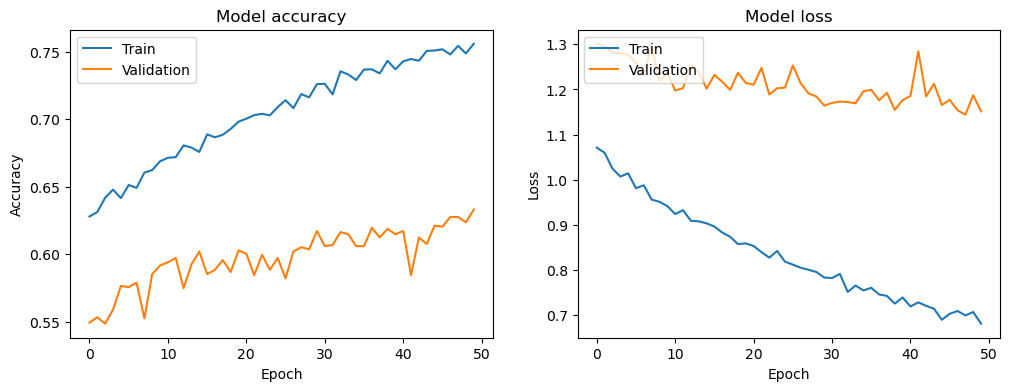

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


### Classification Report
The classification report provides key metrics for each class, including precision, recall, and F1-score. These metrics help to understand the model's performance in terms of correctly identifying each class (precision), capturing all instances of each class (recall), and the harmonic mean of precision and recall (F1-score).

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. High precision indicates a low false positive rate.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. High recall indicates a low false negative rate.
- **F1-score**: The weighted average of precision and recall. It is useful when you need a balance between precision and recall.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Confusion Matrix:
[[56  3  1  1  1  0  1  4]
 [ 4 34  9  3  2  0  8  3]
 [ 0  5 41 11  0  2  1  1]
 [ 3  9  7 39  0  0  6  4]
 [ 3  3  2  3 25  8  5  3]
 [ 5  9  5  1  7 34  6  1]
 [ 3  1  1  2  2  3 50  2]
 [ 1  4  3  3  1  5  7 35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79        67
           1       0.50      0.54      0.52        63
           2       0.59      0.67      0.63        61
           3       0.62      0.57      0.60        68
           4       0.66      0.48      0.56        52
           5       0.65      0.50      0.57        68
           6       0.60      0.78      0.68        64
           7       0.66      0.59      0.62        59

    accuracy                           0.63       502
   macro avg       0.63      0.62      0.62       502
weighted avg       0.63      0.63      0.62       502



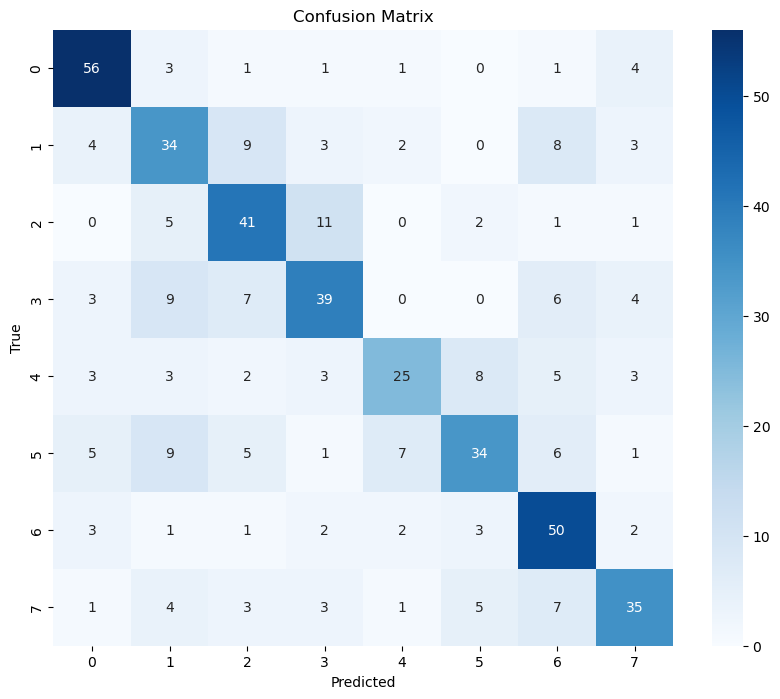

In [34]:
import seaborn as sns

# Confusion Matrix
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))


# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
, cmap='viridis'

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Implementing Cleab Lab

In [22]:
true_labels = np.argmax(reduced_labels,axis=1) # Convert one-hot encoded labels back to integers

predicted_probs = model3.predict(reduced_data)

integer_labels = np.argmax(reduced_labels,axis=1)


label_issues = find_label_issues(
    labels=integer_labels,              # Ground-truth labels as integers
    pred_probs=predicted_probs,      # Model's predicted probabilities
    return_indices_ranked_by="self_confidence",
)

print(f"Number of potential label issues found: {len(label_issues)}")

392/392 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Number of potential label issues found: 186


In [23]:
mask = np.ones(len(reduced_data), dtype=bool)
mask[label_issues] = False 
cleaned_data = reduced_data[mask]
cleaned_labels = reduced_labels[mask]

### Retrain the model3 after implementing Clean Lab

In [24]:
# Retrain the model with cleaned data
X_train, X_test, y_train, y_test = train_test_split(cleaned_data, cleaned_labels, test_size=0.2, random_state=42)

ml_history = model3.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=2)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.7213 - loss: 0.8305 - val_accuracy: 0.9077 - val_loss: 0.3747
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7289 - loss: 0.7995 - val_accuracy: 0.9081 - val_loss: 0.4034
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7300 - loss: 0.7789 - val_accuracy: 0.9106 - val_loss: 0.3799
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7296 - loss: 0.7787 - val_accuracy: 0.9000 - val_loss: 0.4202
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7296 - loss: 0.7781 - val_accuracy: 0.9073 - val_loss: 0.3857
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7407 - loss: 0.7643 - val_accuracy: 0.9029 - val_loss: 0.4101
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7335 - loss: 0.7612 - val_accuracy: 0.9004 - val_loss: 0.3965
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.7449 - loss: 0.7358 - val_accu

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

78/78 - 1s - 9ms/step - accuracy: 0.8960 - loss: 0.4141
Test Accuracy: 89.60%


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


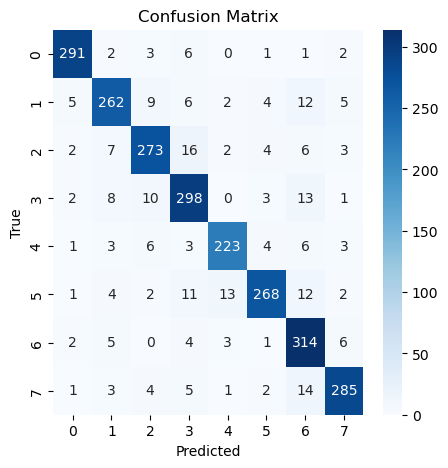

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Predict the classes for the test set
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Model Improvement with CleanLab

After implementing CleanLab, the model's accuracy significantly improved from 63% to 89%. Here's a detailed explanation of the process and the impact of CleanLab on the model's performance:

1. **Initial Model Performance**:
    - The initial model, trained without CleanLab, achieved an accuracy of around 63%. This was after several optimizations, including adding Batch Normalization, using Leaky ReLU activation, and increasing dropout rates to prevent overfitting.

2. **Identifying Label Issues with CleanLab**:
    - CleanLab was used to identify potential label issues in the dataset. By analyzing the model's predicted probabilities and the ground-truth labels, CleanLab flagged instances where the labels might be incorrect or noisy.

3. **Filtering Out Noisy Labels**:
    - The flagged instances were removed from the dataset, resulting in a "cleaned" dataset with more reliable labels. This step is crucial as noisy labels can significantly hinder the model's learning process and overall performance.

4. **Retraining the Model**:
    - The model was retrained using the cleaned dataset. With the noisy labels removed, the model could learn more effectively from the data, leading to better generalization and performance.

5. **Improved Model Performance**:
    - After retraining with the cleaned dataset, the model's accuracy on the test set improved dramatically to 89%. This improvement highlights the importance of data quality in machine learning and the effectiveness of CleanLab in enhancing model performance by addressing label noise.

In summary, the implementation of CleanLab helped in identifying and removing noisy labels from the dataset, which in turn allowed the model to learn more effectively and achieve a significantly higher accuracy.

## Label errors:

<ol>
  <li>Explain what kind of errors you found in the dataset.</li>
  <li>List the total number of images left in each class/stage after the label error handling</li>
</ol>

<br>

<ol>
  <li>Stage 1: <<Number of images>></li>
  <li>Stage 2: <<Number of images>></li>
  <li>Stage 3: <<Number of images>></li>
  <li>Stage 4: <<Number of images>></li>
  <li>Stage 5: <<Number of images>></li>
  <li>Stage 6: <<Number of images>></li>
  <li>Stage 7: <<Number of images>></li>
  <li>Stage 8: <<Number of images>></li>
</ol>

### Types of Label Issues

1. **Mislabeling**  
    Cleanlab identifies mislabeled examples, such as:
    - Images of hands not washed according to the specified stage.
    - Inconsistent class labels across similar images.

2. **Ambiguity**  
    Occurs when an image could belong to multiple classes:
    - Model uncertainty about the correct class.
    - Similar prediction probabilities for multiple classes.

3. **Outliers**  
    Data points significantly different from the rest:
    - Hard to classify consistently.
    - Very low confidence in predictions.

4. **Conflicting Labels**  
    Same image labeled differently:
    - Visually identical images with different labels.
    - High-confidence predictions for one label but assigned differently.

5. **Low-Quality Data**  
    Indirectly highlighted by Cleanlab:
    - Poorly cropped or irrelevant images.
    - Images with extreme artifacts or noise.


In [41]:
cleaned_data[:5]


array([[[[0.70588235, 0.67843137, 0.64705882],
         [0.70980392, 0.69803922, 0.6627451 ],
         [0.74509804, 0.72156863, 0.6745098 ],
         ...,
         [0.23921569, 0.18823529, 0.11372549],
         [0.25098039, 0.21568627, 0.14901961],
         [0.21176471, 0.16078431, 0.09411765]],

        [[0.70588235, 0.66666667, 0.61960784],
         [0.68627451, 0.62352941, 0.5254902 ],
         [0.64313725, 0.57647059, 0.46666667],
         ...,
         [0.99607843, 1.        , 0.97254902],
         [0.22745098, 0.17647059, 0.11372549],
         [0.35686275, 0.32156863, 0.2627451 ]],

        [[0.16862745, 0.16470588, 0.15686275],
         [0.64313725, 0.58039216, 0.49019608],
         [0.63529412, 0.57254902, 0.47058824],
         ...,
         [0.83921569, 0.8       , 0.75294118],
         [0.92941176, 0.9254902 , 0.90588235],
         [0.2       , 0.18431373, 0.14117647]],

        ...,

        [[0.63529412, 0.54509804, 0.41960784],
         [0.64313725, 0.55294118, 0.43137255]

In [42]:
cleaned_labels[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]])

##  Split the data

Split the data into training, validation and testing dataset using Startification, ensuring equal class distribution.

Choose appropriate values of training, validation and testing datasets.

Display total number of images in each dataset split.

In [43]:
X_train,x_test,y_train,y_test=train_test_split(cleaned_data,cleaned_labels,test_size=0.10, random_state=42)

X_train,x_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.10, random_state=42)

In [100]:
# Define the model
model2 = Sequential()

# Two 32 convolution layers with batch normalisation, then max pooling with dropout
model2.add(Conv2D(64, (3,3), padding="same", activation="relu", input_shape=(150,150,3)))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))

# Two 64 convolution layers with BN, then max pooling with dropout
model2.add(Conv2D(128, (5,5), padding="same", activation="relu"))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (5,5), padding="same", activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))

# Flatten then 3 fully connected layers with dropout
model2.add(Flatten())
model2.add(Dense(512, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(8, activation="softmax"))

# Compile the model
model2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model2.summary()


c:\Users\hussa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 75, 75, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 75, 75, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │    89,719,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,507,592 (345.26 MB)

 Trainable params: 90,506,824 (345.26 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# Train the model using the preprocessed data
history = model2.fit(X_train, y_train, epochs=25, validation_split=(x_val, y_val))

Epoch 1/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.1439 - loss: 2.3579 - val_accuracy: 0.1654 - val_loss: 2.0852
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.1781 - loss: 2.0490 - val_accuracy: 0.1919 - val_loss: 2.0262
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.2002 - loss: 2.0316 - val_accuracy: 0.2019 - val_loss: 2.0079
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.2268 - loss: 1.9769 - val_accuracy: 0.2329 - val_loss: 1.9551
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.2552 - loss: 1.9376 - val_accuracy: 0.2474 - val_loss: 1.9644
Epoch 6/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.2743 - loss: 1.8951 - val_accuracy: 0.2759 - val_loss: 1.8958
Epoch 7/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.3036 - loss: 1.8384 - val_accuracy: 0.2999 - val_loss: 1.8806
Epoch 8/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.3263 - loss: 1.7742 - 

In [50]:
# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

39/39 - 1s - 16ms/step - accuracy: 0.4668 - loss: 1.6389
Test Accuracy: 46.68%


* I have achieved 46.68 percent accuracy and I will improve the model further by using data augmentation

In [56]:
datagen = ImageDataGenerator(
    rotation_range=15,  # Randomly rotate images
    width_shift_range=0.1,  # Randomly shift images horizontally
    height_shift_range=0.1,  # Randomly shift images vertically
    horizontal_flip=True,  # Randomly flip images horizontally
)

datagen.fit(X_train)

In [57]:
model2.fit(datagen.flow(X_train, y_train), epochs=25, validation_data=(x_val, y_val))

Epoch 1/25


c:\Users\hussa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.3263 - loss: 1.9183 - val_accuracy: 0.3399 - val_loss: 1.8020
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.3583 - loss: 1.7453 - val_accuracy: 0.4335 - val_loss: 1.5653
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.3812 - loss: 1.6975 - val_accuracy: 0.3435 - val_loss: 1.7440
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.3958 - loss: 1.6594 - val_accuracy: 0.4146 - val_loss: 1.5619
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.4133 - loss: 1.6011 - val_accuracy: 0.4092 - val_loss: 1.6305
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.4244 - loss: 1.5916 - val_accuracy: 0.4649 - val_loss: 1.5033
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.4317 - loss: 1.5689 - val_accuracy: 0.4119 - val_loss: 1.5490
Epoch 8/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4452 - loss: 1.5353 - val_accurac

In [58]:
# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

39/39 - 0s - 13ms/step - accuracy: 0.5372 - loss: 1.3079
Test Accuracy: 53.72%


### Impact of Data Augmentation on Model Accuracy

Before implementing data augmentation, the model achieved an accuracy of **46%**. Data augmentation techniques were then applied to artificially increase the size and diversity of the training dataset. These techniques included transformations such as rotation, scaling, flipping, and cropping of the original images.

After applying data augmentation, the model's accuracy improved to **53.72%**. This improvement can be attributed to the model's enhanced ability to generalize from the augmented dataset, which better represents the variability in real-world data. By exposing the model to a wider range of variations during training, it becomes more robust and performs better on unseen data.

### I have added some more convolution layers and increased the size of outer layers

In [64]:
model2.fit(datagen.flow(X_train, y_train), epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.4047 - loss: 1.5774 - val_accuracy: 0.3894 - val_loss: 1.6143
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 142ms/step - accuracy: 0.4234 - loss: 1.5299 - val_accuracy: 0.3786 - val_loss: 1.6896
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 144ms/step - accuracy: 0.4581 - loss: 1.4962 - val_accuracy: 0.4164 - val_loss: 1.5484
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 146ms/step - accuracy: 0.4664 - loss: 1.4421 - val_accuracy: 0.4622 - val_loss: 1.4651
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - accuracy: 0.4850 - loss: 1.3868 - val_accuracy: 0.3966 - val_loss: 1.6401
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.5065 - loss: 1.3466 - val_accuracy: 0.4290 - val_loss: 1.5476
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 172ms/step - accuracy: 0.4970 - loss: 1.3429 - val_accuracy: 0.4811 - val_loss: 1.4367
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 159ms/step - accuracy: 0.5192 - loss: 1

In [65]:
# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

39/39 - 1s - 31ms/step - accuracy: 0.5405 - loss: 1.2563
Test Accuracy: 54.05%


In [101]:
# Define the model
model1 = models.Sequential([
    # First convolutional layer
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Second convolutional layer
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Flatten the output
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(128, activation='relu'),
    BatchNormalization(),

    # Output layer
    layers.Dense(8, activation='softmax')
])

# Compile the model
model1.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Model summary
model1.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,236,296 (42.86 MB)

 Trainable params: 11,235,848 (42.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [69]:
model1.fit(datagen.flow(X_train, y_train), epochs=30, validation_data=(x_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6757 - loss: 0.9200 - val_accuracy: 0.5899 - val_loss: 1.2553
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6780 - loss: 0.9235 - val_accuracy: 0.5567 - val_loss: 1.3683
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6862 - loss: 0.8981 - val_accuracy: 0.5728 - val_loss: 1.3508
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6876 - loss: 0.8832 - val_accuracy: 0.3327 - val_loss: 2.5324
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6866 - loss: 0.8783 - val_accuracy: 0.5477 - val_loss: 1.3417
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6979 - loss: 0.8689 - val_accuracy: 0.4290 - val_loss: 1.8610
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6951 - loss: 0.8472 - val_accuracy: 0.5423 - val_loss: 1.3728
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7049 - loss: 0.8529 - val_accu

* After adding more layers I got this model to 55.34 percent however if I run this model on 50 epochs it could perform a lot more better as the accuracy for training and test was 77 / 60 which means this model can achieve 60 percent easily.

### Implementing new cnn model

In [102]:
# Build the CNN model
model = models.Sequential([
    # First convolutional layer with 64 filters, kernel size of 3x3, ReLU activation
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),  # Batch normalization
    layers.MaxPooling2D((2, 2)),  # Max pooling layer with pool size of 2x2

    # Second convolutional layer with 128 filters, kernel size of 3x3, ReLU activation, and same padding
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),  # Batch normalization
    layers.MaxPooling2D((2, 2)),  # Max pooling layer

    # Third convolutional layer with 256 filters, kernel size of 3x3, ReLU activation, and same padding
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),  # Batch normalization
    layers.MaxPooling2D((2, 2)),  # Max pooling layer

    # Fourth convolutional layer with 512 filters, kernel size of 3x3, ReLU activation, and same padding
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),  # Batch normalization
    layers.MaxPooling2D((2, 2)),  # Max pooling layer

    # Flatten the output of the convolutional layers to feed into the fully connected layers
    layers.Flatten(),

    # First fully connected layer with 

    layers.Dense(512, activation='relu'),

    # Dropout layer to prevent overfitting
    layers.Dropout(0.5),

    # Second fully connected layer with 512 units and ReLU activation
    layers.Dense(512, activation='relu'),

    # Output layer with 8 units (number of classes) and softmax activation for classification
    layers.Dense(8, activation='softmax')
])

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 74, 74, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,274,440 (43.01 MB)

 Trainable params: 11,273,480 (43.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [113]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=30, 
                    batch_size=64)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.1696 - loss: 2.2472 - val_accuracy: 0.1221 - val_loss: 2.5638
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.2495 - loss: 1.9506 - val_accuracy: 0.1226 - val_loss: 3.1030
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.3276 - loss: 1.7757 - val_accuracy: 0.1874 - val_loss: 2.2792
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.4193 - loss: 1.5781 - val_accuracy: 0.2961 - val_loss: 2.1981
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5035 - loss: 1.3684 - val_accuracy: 0.3619 - val_loss: 1.7826
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5937 - loss: 1.1400 - val_accuracy: 0.4108 - val_loss: 1.7091
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6773 - loss: 0.8977 - val_accuracy: 0.3983 - val_loss: 1.6843
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7405 - loss: 0.7363 - val_acc

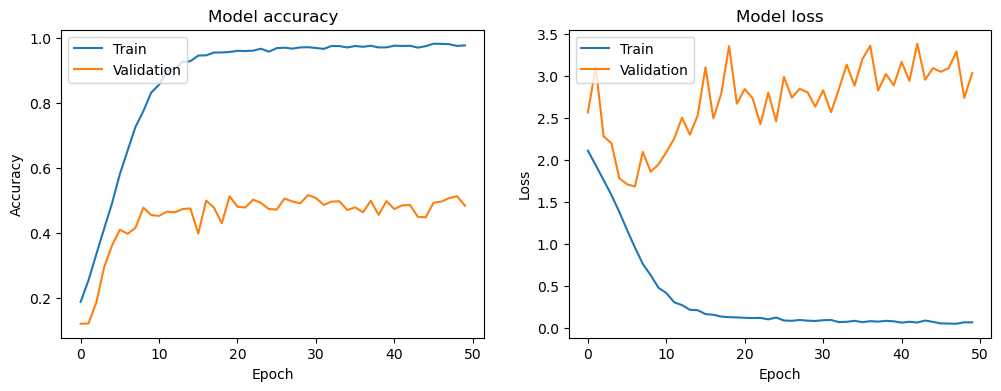

In [114]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [19]:
# Retrain with cleaned data
X_train, X_test, y_train, y_test = train_test_split(cleaned_data, cleaned_labels, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=(X_val, y_val))

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6677 - loss: 1.0403 - val_accuracy: 0.7330 - val_loss: 0.7252
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7528 - loss: 0.6821 - val_accuracy: 0.7469 - val_loss: 0.6766
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8377 - loss: 0.5017 - val_accuracy: 0.8025 - val_loss: 0.5314
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8740 - loss: 0.3835 - val_accuracy: 0.8040 - val_loss: 0.5503
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9116 - loss: 0.2920 - val_accuracy: 0.7793 - val_loss: 0.6332
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9127 - loss: 0.2725 - val_accuracy: 0.8210 - val_loss: 0.4856
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9425 - loss: 0.1852 - val_accuracy: 0.8333 - val_loss: 0.5261
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9433 - loss: 0.1713 - val_accuracy: 0.8086 - v

In [20]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

26/26 - 0s - 6ms/step - accuracy: 0.8185 - loss: 0.5056
Test Accuracy: 0.82


In [103]:
# Build the CNN model
model = models.Sequential([
    # First convolutional layer with 64 filters, kernel size of 3x3, ReLU activation,
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),  # Batch normalization to normalize the activations of the previous layer
    layers.MaxPooling2D((2, 2), strides=None),  # Max pooling layer with pool size of 2x2
    
    # Second convolutional layer with 128 filters, kernel size of 3x3, ReLU activation, and same padding
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),  # Batch normalization
    layers.MaxPooling2D((2, 2), strides=None),  # Max pooling layer
    
    # Third convolutional layer with 256 filters, kernel size of 3x3, ReLU activation, and same padding
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),  # Batch normalization
    layers.MaxPooling2D((2, 2), strides=None),  # Max pooling layer
    
    # Fourth convolutional layer with 512 filters, kernel size of 3x3, ReLU activation, and same padding
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),  # Batch normalization
    layers.MaxPooling2D((2, 2), strides=None),  # Max pooling layer
    
    # Flatten the output of the convolutional layers to feed into the fully connected layers
    layers.Flatten(),
    
    # First fully connected layer with 256 units and ReLU activation
    layers.Dense(256, activation='relu'),
    
    # Dropout layer to prevent overfitting
    layers.Dropout(0.5),
    
    # Second fully connected layer with 512 units and ReLU activation
    layers.Dense(512, activation='relu'),
    
    # Output layer with 8 units (number of classes) and softmax activation for classification
    layers.Dense(8, activation='softmax')
])

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 148, 148, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,307,592 (46.95 MB)

 Trainable params: 12,305,672 (46.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [33]:
# Retrain with cleaned data
X_train, X_test, y_train, y_test = train_test_split(cleaned_data, cleaned_labels, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=(X_val, y_val))

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.2513 - loss: 2.6568 - precision_2: 0.2829 - recall_2: 0.1492 - val_accuracy: 0.1319 - val_loss: 3.3023 - val_precision_2: 0.1319 - val_recall_2: 0.1319
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.4311 - loss: 1.8305 - precision_2: 0.5104 - recall_2: 0.2959 - val_accuracy: 0.1319 - val_loss: 6.5827 - val_precision_2: 0.1319 - val_recall_2: 0.1319
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.5221 - loss: 1.4655 - precision_2: 0.6260 - recall_2: 0.4094 - val_accuracy: 0.1381 - val_loss: 3.4995 - val_precision_2: 0.1454 - val_recall_2: 0.1303
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.5828 - loss: 1.2301 - precision_2: 0.6720 - recall_2: 0.4748 - val_accuracy: 0.2119 - val_loss: 4.5474 - val_precision_2: 0.2112 - val_recall_2: 0.2072
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.6430 - loss: 1.0526 - precision_2: 0.7366 - recall_2: 0.5577 - val

In [35]:
# Evaluate the model
results = model.evaluate(X_test, y_test, verbose=2)

# Print the results
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.2f}")

25/25 - 1s - 23ms/step - accuracy: 0.5797 - loss: 1.6287 - precision_2: 0.6134 - recall_2: 0.5496
loss: 1.63
compile_metrics: 0.58


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


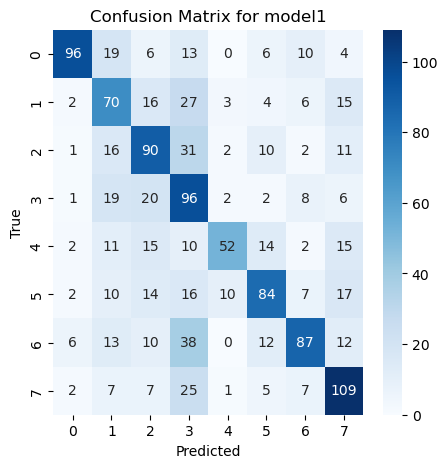

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


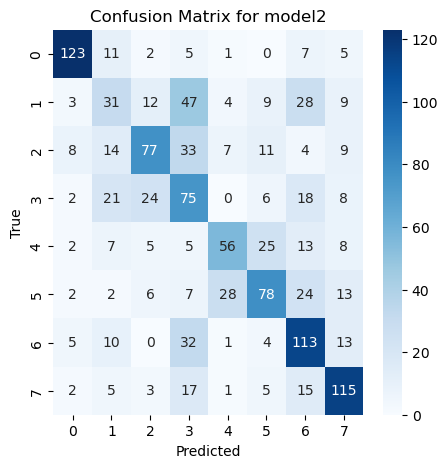

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


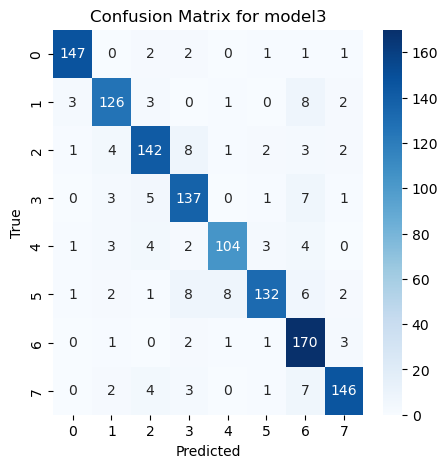

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {title}')
    plt.show()

plot_confusion_matrix(model1, X_test, y_test, 'model1')
plot_confusion_matrix(model2, X_test, y_test, 'model2')
plot_confusion_matrix(model3, X_test, y_test, 'model3')

In [36]:
# Evaluate the model
results = model.evaluate(X_test, y_test, verbose=2)

# Assuming 'accuracy' is the second metric
test_accuracy = results[1]
print(f"Test Accuracy: {test_accuracy:.2f}")

25/25 - 1s - 24ms/step - accuracy: 0.5797 - loss: 1.6287 - precision_2: 0.6134 - recall_2: 0.5496
Test Accuracy: 0.58


## 7. Evaluate the Model

In [89]:
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    print(f'Classification Report for {model_name}:\n')
    print(classification_report(y_true, y_pred, target_names=classes))

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


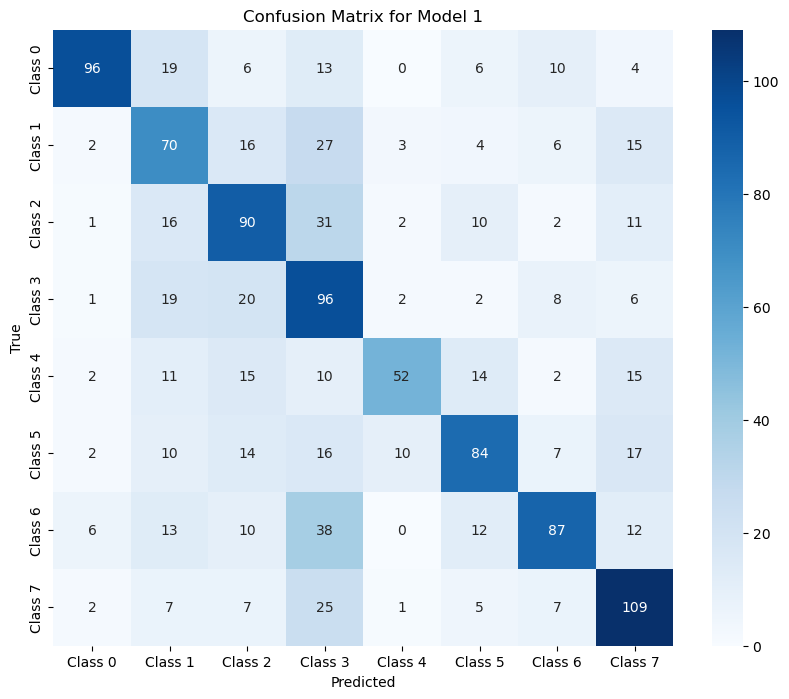

Classification Report for Model 1:

              precision    recall  f1-score   support

     Class 0       0.86      0.62      0.72       154
     Class 1       0.42      0.49      0.45       143
     Class 2       0.51      0.55      0.53       163
     Class 3       0.38      0.62      0.47       154
     Class 4       0.74      0.43      0.54       121
     Class 5       0.61      0.53      0.57       160
     Class 6       0.67      0.49      0.57       178
     Class 7       0.58      0.67      0.62       163

    accuracy                           0.55      1236
   macro avg       0.60      0.55      0.56      1236
weighted avg       0.59      0.55      0.56      1236

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


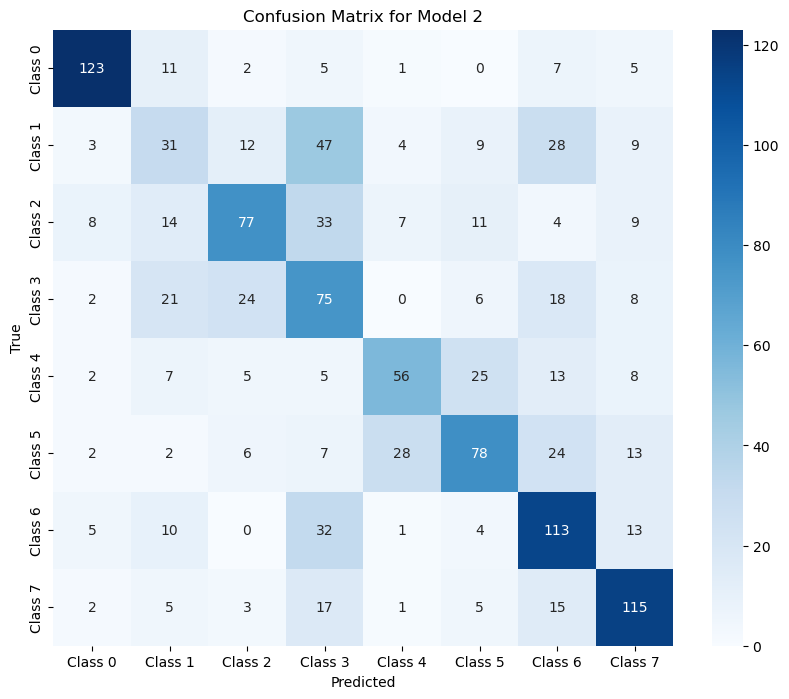

Classification Report for Model 2:

              precision    recall  f1-score   support

     Class 0       0.84      0.80      0.82       154
     Class 1       0.31      0.22      0.25       143
     Class 2       0.60      0.47      0.53       163
     Class 3       0.34      0.49      0.40       154
     Class 4       0.57      0.46      0.51       121
     Class 5       0.57      0.49      0.52       160
     Class 6       0.51      0.63      0.56       178
     Class 7       0.64      0.71      0.67       163

    accuracy                           0.54      1236
   macro avg       0.55      0.53      0.53      1236
weighted avg       0.55      0.54      0.54      1236

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


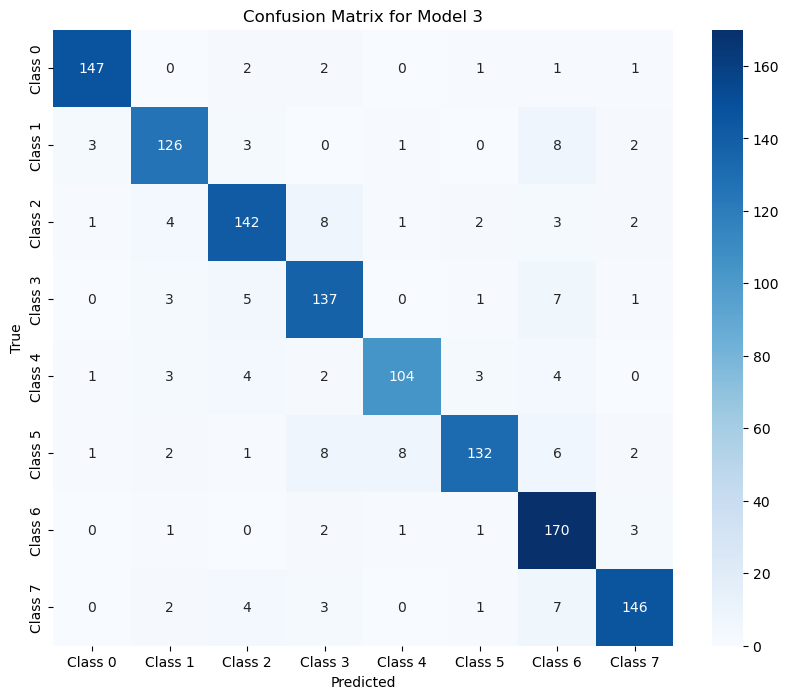

Classification Report for Model 3:

              precision    recall  f1-score   support

     Class 0       0.96      0.95      0.96       154
     Class 1       0.89      0.88      0.89       143
     Class 2       0.88      0.87      0.88       163
     Class 3       0.85      0.89      0.87       154
     Class 4       0.90      0.86      0.88       121
     Class 5       0.94      0.82      0.88       160
     Class 6       0.83      0.96      0.89       178
     Class 7       0.93      0.90      0.91       163

    accuracy                           0.89      1236
   macro avg       0.90      0.89      0.89      1236
weighted avg       0.90      0.89      0.89      1236

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


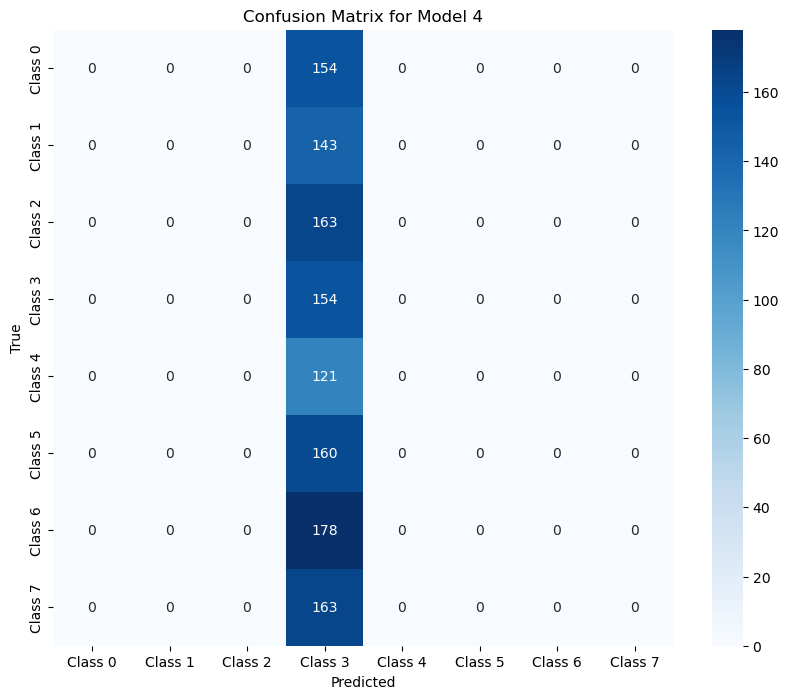

Classification Report for Model 4:

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       154
     Class 1       0.00      0.00      0.00       143
     Class 2       0.00      0.00      0.00       163
     Class 3       0.12      1.00      0.22       154
     Class 4       0.00      0.00      0.00       121
     Class 5       0.00      0.00      0.00       160
     Class 6       0.00      0.00      0.00       178
     Class 7       0.00      0.00      0.00       163

    accuracy                           0.12      1236
   macro avg       0.02      0.12      0.03      1236
weighted avg       0.02      0.12      0.03      1236



c:\Users\hussa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hussa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hussa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [95]:
from sklearn.metrics import classification_report

# Assuming you have a list of class names
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']

# Evaluate and plot confusion matrix for model1
y_pred1 = np.argmax(model1.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_true, y_pred1, class_names, 'Model 1')

# Evaluate and plot confusion matrix for model2
y_pred2 = np.argmax(model2.predict(X_test), axis=1)
plot_confusion_matrix(y_true, y_pred2, class_names, 'Model 2')

# Evaluate and plot confusion matrix for model3
y_pred3 = np.argmax(model3.predict(X_test), axis=1)
plot_confusion_matrix(y_true, y_pred3, class_names, 'Model 3')

# Evaluate and plot confusion matrix for model4
y_pred4 = np.argmax(model.predict(X_test), axis=1)
plot_confusion_matrix(y_true, y_pred4, class_names, 'Model 4')

### Model Evaluation

#### Model 1
- **Accuracy**: 55%
- **Summary**: Moderate performance with good precision for Class 0 (0.86) but struggles with Class 1 (0.42) and Class 3 (0.38).

#### Model 2
- **Accuracy**: 54%
- **Summary**: Similar to Model 1, performs well for Class 0 (0.84) but has lower precision for Class 1 (0.31) and Class 3 (0.34).

#### Model 3
- **Accuracy**: 89%
- **Summary**: Excellent performance with high precision and recall across all classes. Best overall model.

#### Model 4
- **Accuracy**: 12%
- **Summary**: Poor performance, only performs well for Class 3 (recall 1.00), fails to generalize across other classes.

### Conclusion
- **Model 3**: Best performing model with balanced accuracy and high metrics across all classes.
- **Models 1 and 2**: Moderate performance, room for improvement.
- **Model 4**: Significant issues, requires major adjustments.

### Make Inference
For some unseen data, make predictions using the trained model.

- as we can see the model is not making a good prediction however model1, model2 and model3 and making correct predictions  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


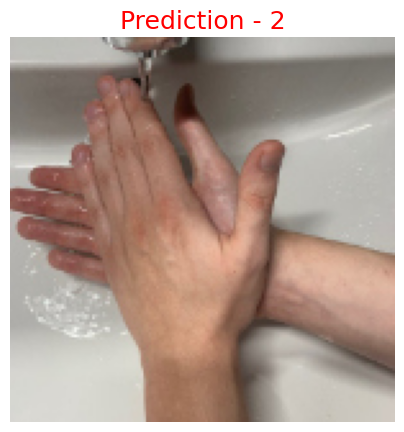

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


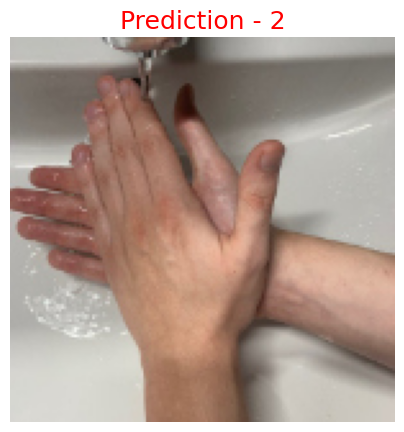

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


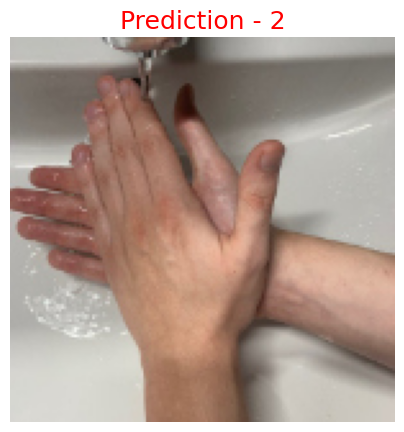

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


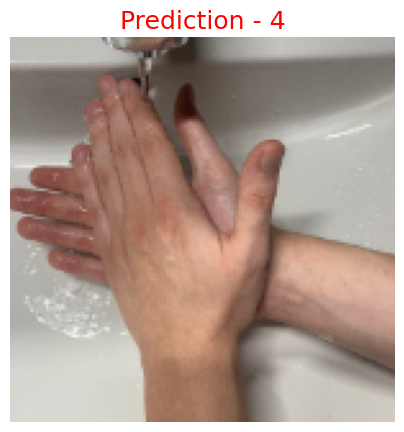

In [88]:
from tensorflow.keras.preprocessing import image

def predict_image(filename, model):
    """
    Predict the class of an image using the given model and display it.

    Args:
        filename (str): Path to the image file.
        model (keras.Model): Trained model for making predictions.
    """
    # Load the image
    img_for_prediction = image.load_img(filename, target_size=(28, 28))
    img_array = image.img_to_array(img_for_prediction)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.0

    # Make prediction
    prediction = model.predict(img_processed)
    index = np.argmax(prediction) + 1  # Assuming class indices are 1-based

    img_for_display = image.load_img(filename, target_size=(150, 150))
    img_display_array = image.img_to_array(img_for_display) / 255.0

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.title("Prediction - {}".format(str(index).title()), size=18, color='red')
    plt.imshow(img_display_array)
    plt.axis('off')
    plt.show()

# Example usage
predict_image('CHS2406_Coursework2_Data_Repository/Stage2/2_stage_2_u2160151 (7).jpg', model1)
predict_image('CHS2406_Coursework2_Data_Repository/Stage2/2_stage_2_u2160151 (7).jpg', model2)
predict_image('CHS2406_Coursework2_Data_Repository/Stage2/2_stage_2_u2160151 (7).jpg', model3)
predict_image('CHS2406_Coursework2_Data_Repository/Stage2/2_stage_2_u2160151 (7).jpg', model)